# Histology Dataset attempt one

In [15]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.color import rgb2gray

import torch
from torch import nn
import kornia as K
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader
import timm

import import_ipynb 
import dl_helper

In [2]:
def read_histo_from_path(path):
    print(f"read from {path}")
    names = []
    labels = []
    for i in os.listdir(path):
        tmp = os.listdir(path+'/'+i)
        names.extend(tmp)
        labels.extend([i] * len(tmp))
    data = []
    new_labels = []
    for i, name in enumerate(names):
        print(f"{i+1}/{len(names)}      ", end="\r")
        read = Image.open(f"{path}/{labels[i]}/{name}")
        if read.size == (50, 50) and read.mode == 'RGB':
            # data.append(rgb2gray(read))
            tmp = TF.to_tensor(read)
            data.append(tmp.reshape(1, *tmp.shape))
            new_labels.append(int(labels[i][0]))
    data = torch.cat(data)
    labels = torch.tensor(new_labels)
    print('')
    return data, labels

def read_img(path='/train'):
    path = "../data/Breast Histopathology Images SMALL"+path
    x, y = read_histo_from_path(path)
    # return reshape(x), y
    return x, y


def read_histo_small():
    path = "../data/Breast Histopathology Images SMALL"
    train_path = path+'/train'
    val_path = path+'/valid'
    test_path = path+'/test'
    x_train, y_train = read_histo_from_path(train_path)
    x_val, y_val = read_histo_from_path(val_path)
    x_test, y_test = read_histo_from_path(test_path)
    # return reshape(x_train), y_train, reshape(x_val), y_val,reshape(x_test), y_test
    return x_train, y_train, x_val, y_val, x_test, y_test

def reshape(x):
    return x.permute(0,3,2,1)

In [3]:
x_train, y_train = read_img('/train') 
x_val, y_val = read_img('/valid')
x_test, y_test = read_img('/test')

read from ../data/Breast Histopathology Images SMALL/train
19426/19426      
read from ../data/Breast Histopathology Images SMALL/valid
4163/4163      
read from ../data/Breast Histopathology Images SMALL/test
4162/4162      


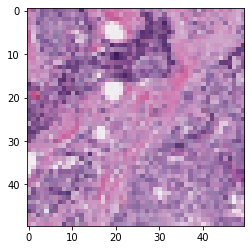

In [4]:
plt.imshow(x_train[0].permute(1,2,0), cmap='magma')

In [5]:
# Taken from here https://stackoverflow.com/a/58748125/1983544
num_workers = os.cpu_count() 
if 'sched_getaffinity' in dir(os):
    num_workers = len(os.sched_getaffinity(0))
print (num_workers)

12


In [6]:
batch_size = 32
train_dataloader = DataLoader(list(zip(x_train, y_train)),
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers = num_workers)
valid_dataloader = DataLoader(list(zip(x_val, y_val)),
                              batch_size=batch_size,
                              shuffle=False,
                              drop_last=False,
                              num_workers = num_workers)

In [7]:
model = timm.create_model('resnet50', pretrained=True)

In [8]:
model.default_cfg

{'url': 'https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.95,
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'conv1',
 'classifier': 'fc',
 'architecture': 'resnet50'}

In [9]:
model = timm.create_model('resnet50', pretrained=True, num_classes=10)
print(model.fc)

Linear(in_features=2048, out_features=10, bias=True)


In [10]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-3
lambda_l2 = 1e-4
optimizer = torch.optim.Adam(model.fc.parameters(),
                             lr=learning_rate,
                             eps=1e-2,
                             weight_decay=lambda_l2)  # built-in L2

In [11]:
epochs = 1

In [ ]:
dl_helper.train_epochs(train_dataloader, valid_dataloader, model, loss_fn, optimizer, epochs=epochs)

  0%|          | 0/130 [00:00<?, ?it/s]

/home/jackred/anaconda3/envs/pDL/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-pma2oi4d/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


KeyboardInterrupt: 

'cpu'